In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/as22/fruits-360_dataset.zip /content
!unzip /content/fruits-360_dataset.zip

!pip install datasets
!pip install transformers
!pip install accelerate -U


# Problem 1

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/fruits-360_dataset/fruits-360'
train_path = base_path + '/Training'
test_path = base_path + '/Test'


BATCH_SIZE = 1000
IMG_SIZE = (75, 75)
SEED = 42


In [3]:
train_gen, valid_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 67692 files belonging to 131 classes.
Using 57539 files for training.
Using 10153 files for validation.
Found 22688 files belonging to 131 classes.


In [8]:
from tensorflow.keras.applications import ResNet101, InceptionV3, EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
import time
import matplotlib.pyplot as plt


def create_and_train_model(base_model, train_gen, test_gen, freeze_layers=True):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers:
          layer.trainable = False

    # Add Flatten layer
    # x = Flatten()(base_model.output)

    # Add GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Modify pre-trained model
    output = Dense(131, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=50)


    # Plotting Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    return num_params, inference_time, accuracy


## ResNet101

171446536/171446536 [==============================] - 9s 0us/step
Epoch 1/50
58/58 [==============================] - 28s 194ms/step - loss: 1.2347 - accuracy: 0.7642 - val_loss: 0.1652 - val_accuracy: 0.9798
Epoch 2/50
58/58 [==============================] - 8s 143ms/step - loss: 0.0954 - accuracy: 0.9929 - val_loss: 0.0678 - val_accuracy: 0.9957
Epoch 3/50
58/58 [==============================] - 8s 142ms/step - loss: 0.0465 - accuracy: 0.9988 - val_loss: 0.0415 - val_accuracy: 0.9982
Epoch 4/50
58/58 [==============================] - 8s 142ms/step - loss: 0.0295 - accuracy: 0.9995 - val_loss: 0.0290 - val_accuracy: 0.9993
Epoch 5/50
58/58 [==============================] - 8s 143ms/step - loss: 0.0207 - accuracy: 0.9998 - val_loss: 0.0221 - val_accuracy: 0.9992
Epoch 6/50
58/58 [==============================] - 8s 142ms/step - loss: 0.0157 - accuracy: 0.9999 - val_loss: 0.0179 - val_accuracy: 0.9994
Epoch 7/50
58/58 [==============================] - 8s 142ms/step - loss: 0.0124

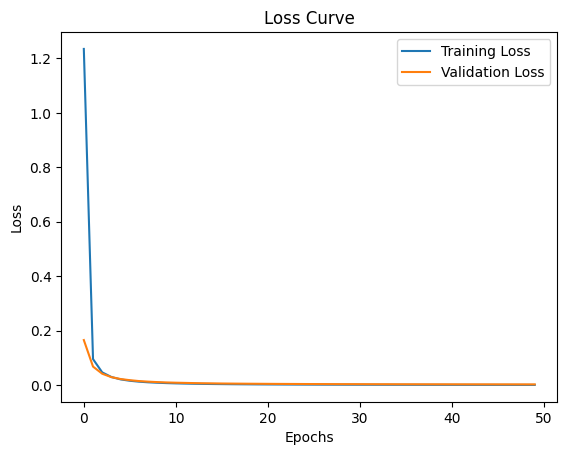

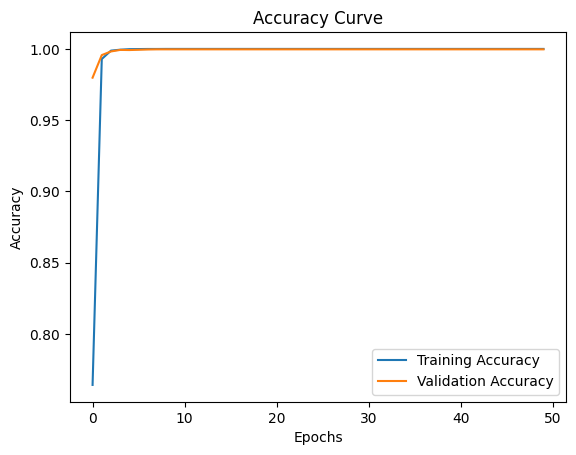

23/23 [==============================] - 4s 155ms/step - loss: 0.1712 - accuracy: 0.9628
ResNet101: Params=42926595, Time=4.070730209350586, Accuracy=0.9627556204795837


In [5]:
# Create and train ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
resnet_params, resnet_time, resnet_acc = create_and_train_model(resnet_base, train_gen, test_gen)
print(f"ResNet101: Params={resnet_params}, Time={resnet_time}, Accuracy={resnet_acc}")



For the ResNet101 model with all pre-trained layers frozen, it is evident that the final training accuracy is 1.00 and the test accuracy is 0.96. The training loss decreases rapidly in the first 3 epochs and then approaches 0, while the validation loss also approaches 0. This suggests that the model fits this problem well.

Epoch 1/50
58/58 [==============================] - 91s 429ms/step - loss: 0.2538 - accuracy: 0.9475 - val_loss: 172660.3281 - val_accuracy: 0.0066
Epoch 2/50
58/58 [==============================] - 20s 347ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 88.9694 - val_accuracy: 0.2452
Epoch 3/50
58/58 [==============================] - 20s 348ms/step - loss: 0.0262 - accuracy: 0.9943 - val_loss: 2925.9141 - val_accuracy: 0.0098
Epoch 4/50
58/58 [==============================] - 20s 348ms/step - loss: 0.0290 - accuracy: 0.9936 - val_loss: 647.0030 - val_accuracy: 0.0051
Epoch 5/50
58/58 [==============================] - 20s 347ms/step - loss: 0.0178 - accuracy: 0.9959 - val_loss: 370.0451 - val_accuracy: 0.0123
Epoch 6/50
58/58 [==============================] - 20s 347ms/step - loss: 0.0115 - accuracy: 0.9973 - val_loss: 35.8231 - val_accuracy: 0.0224
Epoch 7/50
58/58 [==============================] - 20s 347ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 1.3098 - val_ac

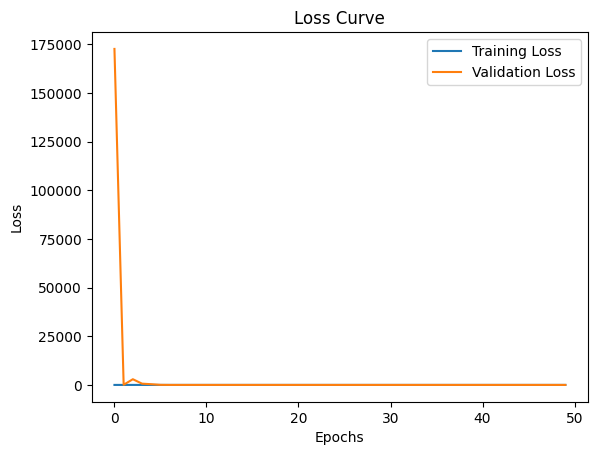

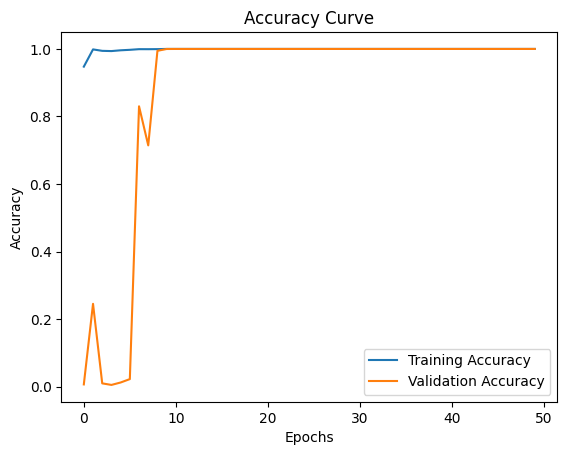

23/23 [==============================] - 3s 120ms/step - loss: 0.0478 - accuracy: 0.9914
ResNet101: Params=42926595, Time=2.7723920345306396, Accuracy=0.9913610816001892


In [9]:
# Create and train ResNet101 WITHOUT freezing layers
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
resnet_params, resnet_time, resnet_acc = create_and_train_model(resnet_base, train_gen, test_gen, freeze_layers=False)
print(f"ResNet101: Params={resnet_params}, Time={resnet_time}, Accuracy={resnet_acc}")

To investigate the role of transfer learning and frozen layers, I repeated the training process with the same hyperparameters but without freezing the pre-trained layers. The final training accuracy was 1.0 and the test accuracy was 0.99, surpassing the model that froze all pre-trained layers. This suggests that unfreezing the pre-trained layers allows for better learning from the training data, resulting in higher accuracy. However, although there was a slight improvement in test accuracy (0.97->0.99), it came at a much longer training time. Therefore, if computation time is a concern, freezing the pre-trained layers is a good choice for this problem.

The above result may be due to the fact that the pre-trained layer already contains sufficient information and knowledge required to solve this specific problem. By adding a dense layer at the end, it can comprehend features extracted by the pre-trained layers and learn their relationship with output classification through training on labeled data. This explains why training a dense layer achieves high accuracy. Based on this understanding, it can be proposed that during transfer learning, we can first freeze and train only the dense layer while keeping pre-trained layers frozen; then we unfreeze and fine-tune these pre-trained layers to achieve higher accuracy while saving computation time.

Moreover, it is interesting to note that the accuracy curve of the validation set exhibits several abrupt drops, which did not occur in the previous model where all pre-trained layers were frozen. This could be attributed to the fact that the pre-trained layer employs dropout as a means to prevent overfitting, whereas the dense layer does not incorporate this technique.


## InceptionV3

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/50
58/58 [==============================] - 11s 91ms/step - loss: 26.6165 - accuracy: 0.3867 - val_loss: 4.6378 - val_accuracy: 0.6726
Epoch 2/50
58/58 [==============================] - 3s 48ms/step - loss: 2.5244 - accuracy: 0.7726 - val_loss: 1.5055 - val_accuracy: 0.8317
Epoch 3/50
58/58 [==============================] - 3s 48ms/step - loss: 0.9762 - accuracy: 0.8784 - val_loss: 0.7874 - val_accuracy: 0.8930
Epoch 4/50
58/58 [==============================] - 3s 48ms/step - loss: 0.5081 - accuracy: 0.9252 - val_loss: 0.5160 - val_accuracy: 0.9259
Epoch 5/50
58/58 [==============================] - 3s 48ms/step - loss: 0.3164 - accuracy: 0.9443 - val_loss: 0.4190 - val_accuracy: 0.9343
Epoch 6/50
58/58 [==============================] - 3s 49ms/step - loss: 0.2281 - accuracy: 0.9570 - val_loss: 0.2801 - val_accuracy: 0.9531
Epoch 7/50
58/58 [==============================] - 3s 48ms/step - loss: 0.1501 - accur

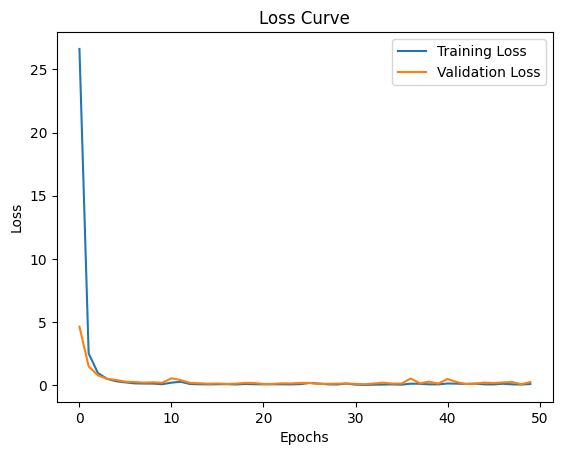

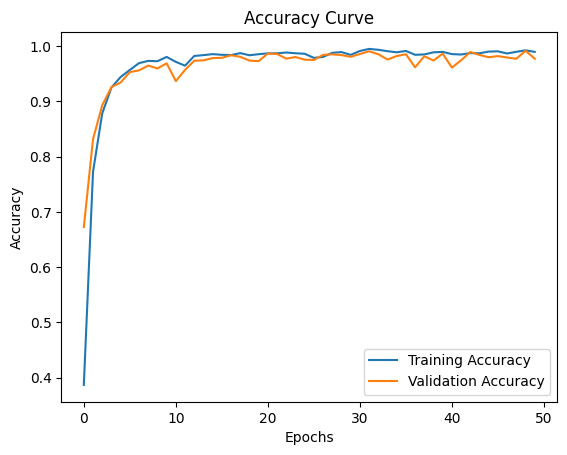

23/23 [==============================] - 2s 76ms/step - loss: 7.9492 - accuracy: 0.7607
InceptionV3: Params=22071203, Time=1.73166823387146, Accuracy=0.7607105374336243


In [6]:
# Create and train InceptionV3
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
inception_params, inception_time, inception_acc = create_and_train_model(inception_base, train_gen, test_gen)
print(f"InceptionV3: Params={inception_params}, Time={inception_time}, Accuracy={inception_acc}")


The InceptionV3 model, with all pre-trained layers frozen, has a training accuracy of 0.9897 and a test accuracy of 0.76. It is evident that these accuracies are lower than those of the ResNet101 model. This discrepancy may be attributed to the greater complexity of the InceptionV3 model compared to the ResNet101 model, necessitating more training data for achieving high accuracy. Additionally, it is worth noting that the validation loss exhibits slight oscillation.

## EfficientNetB1

27018416/27018416 [==============================] - 2s 0us/step
Epoch 1/50
58/58 [==============================] - 18s 132ms/step - loss: 2.5999 - accuracy: 0.5764 - val_loss: 1.1437 - val_accuracy: 0.8882
Epoch 2/50
58/58 [==============================] - 6s 96ms/step - loss: 0.8876 - accuracy: 0.8893 - val_loss: 0.5533 - val_accuracy: 0.9470
Epoch 3/50
58/58 [==============================] - 6s 96ms/step - loss: 0.5265 - accuracy: 0.9387 - val_loss: 0.3533 - val_accuracy: 0.9706
Epoch 4/50
58/58 [==============================] - 6s 95ms/step - loss: 0.3695 - accuracy: 0.9591 - val_loss: 0.2520 - val_accuracy: 0.9829
Epoch 5/50
58/58 [==============================] - 6s 96ms/step - loss: 0.2862 - accuracy: 0.9694 - val_loss: 0.1917 - val_accuracy: 0.9879
Epoch 6/50
58/58 [==============================] - 6s 95ms/step - loss: 0.2281 - accuracy: 0.9779 - val_loss: 0.1524 - val_accuracy: 0.9914
Epoch 7/50
58/58 [==============================] - 6s 95ms/step - loss: 0.1907 - accur

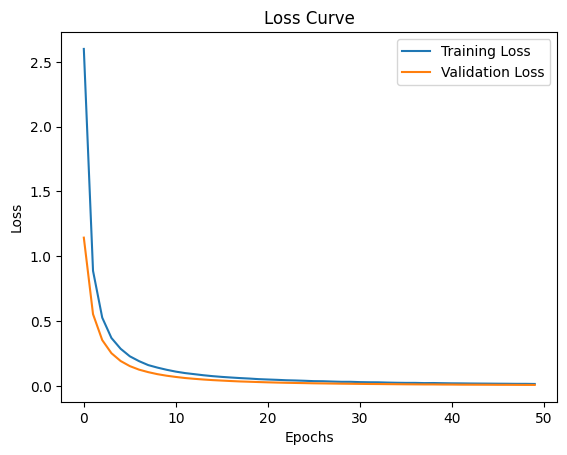

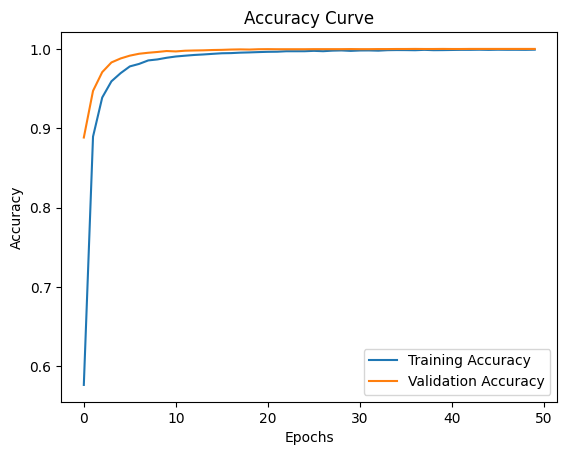

23/23 [==============================] - 2s 81ms/step - loss: 0.1541 - accuracy: 0.9604
EfficientNetB1: Params=6743050, Time=1.8692944049835205, Accuracy=0.9603755474090576


In [7]:
# Create and train EfficientNetB1
effnet_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
effnet_params, effnet_time, effnet_acc = create_and_train_model(effnet_base, train_gen, test_gen)
print(f"EfficientNetB1: Params={effnet_params}, Time={effnet_time}, Accuracy={effnet_acc}")

The training accuracy is 0.9989, and the test accuracy is 0.96, slightly lower than the ResNet101 model. This indicates that the EfficientNetB1 model can also achieve high accuracy on this problem. Although the training epochs before convergence are a bit slower than ResNet101, each epoch's training time is faster. This implies that the EfficientNetB1 model is more computationally efficient while maintaining accuracy.

## Discussion

| Model | Model size | Inference time (s) | Testing accuracy |
| --- | --- | --- | --- |
| Efficient Net B1 | 6,743,050 | 1.87 | 96.0% |
| Inception V3 | 22,071,203 | 1.73 | 76.1% |
| ResNet 101 | 42,926,595 | 4.07 | 96.3% |

The ResNet101 model has the largest model size and inference time, while the EfficientNetB1 model has the smallest model size and much less inference time. The InceptionV3 model has a medium-sized model and the fastest inference time. In terms of testing accuracy, both the ResNet101 and EfficientNetB1 models have similar accuracy, whereas the InceptionV3 model has the lowest accuracy. Therefore, for this problem, the best choice is the EfficientNetB1 model due to its small size, fast inference time, and high accuracy.

# Problem 2

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")
raw_train_dataset = raw_datasets['train'].train_test_split(test_size=1000)
train_dataset = raw_train_dataset['train']
val_dataset = raw_train_dataset['test']
test_dataset = raw_datasets['test']



In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

def tokenize_batch(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_data = train_dataset.map(tokenize_batch, batched=True)
val_data = val_dataset.map(tokenize_batch, batched=True)
test_data = test_dataset.map(tokenize_batch, batched=True)

train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



In [ ]:
from transformers import AlbertForSequenceClassification

model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.247200,0.182516,0.925000
2,0.173000,0.213101,0.937000
3,0.122800,0.284125,0.938000
4,0.076700,0.352288,0.930000
5,0.040400,0.369072,0.935000
6,0.022800,0.442082,0.943000
7,0.012400,0.514923,0.935000
8,0.006100,0.560036,0.936000
9,0.001900,0.621329,0.933000
10,0.000800,0.592462,0.933000


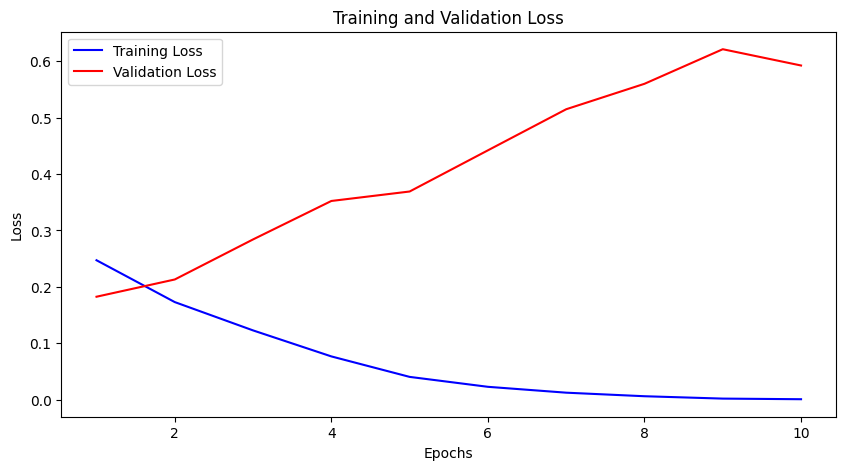

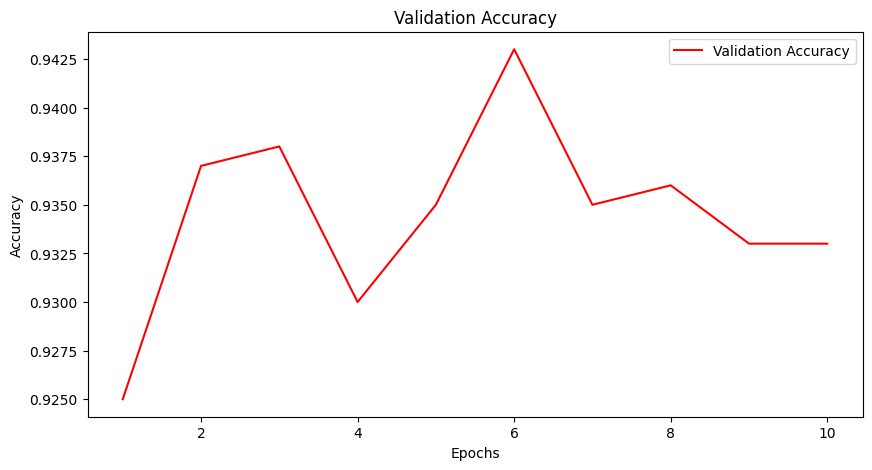

Test Accuracy: 0.93772


In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import TrainerCallback
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_score(labels, predictions)}


class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []
        self.validation_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.training_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.validation_losses.append(logs['eval_loss'])
        if 'eval_accuracy' in logs:
            self.validation_accuracies.append(logs['eval_accuracy'])


metrics_callback = MetricsCallback()

training_args = TrainingArguments(
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    learning_rate=1e-5,
    weight_decay=0.01,
    num_train_epochs=10,
    output_dir='./results'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    callbacks=[metrics_callback],
    compute_metrics=compute_metrics
)

trainer.train()

training_loss = metrics_callback.training_losses
validation_loss = metrics_callback.validation_losses
validation_accuracy = metrics_callback.validation_accuracies

# Assuming that logs are saved every epoch, use this for x-axis
epochs = list(range(1, len(training_loss) + 1))

import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', color='red')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Test the model
evaluation_results = trainer.evaluate(eval_dataset=test_data)
print(f"Test Accuracy: {evaluation_results['eval_accuracy']}")




From the plot of the training and validation loss curves, it is clear that the training loss decreases while the validation loss increases. This suggests that the model is overfitting to the training data. It's strange because this overfitting behavior occurs right from the initial training epoch. One possible explanation for this could be that the pre-trained model has already learned from a large dataset and gained enough knowledge to solve this problem. As a result, even in its first epoch, the model is already overfitting to the training data. Additionally, it's possible that 10 epochs are not sufficient for this problem, and more epochs may be needed for convergence of the model.

In HW2, I achieved a test accuracy of 85% using CNN model, which is lower than the test accuracy of 93.77% obtained here. Moreover, in HW2, I trained for 30 epochs to achieve this accuracy while here I only trained for 10 epochs. This suggests that the pre-trained model needs less epochs than CNN model in this problem. However, on same machine CNN model took 2s per epoch whereas this model took around 10 minutes per epoch. This indicates that CNN model is computationally more efficient than pre-trained ALBERT model. Additionally both models tend to overfit after several epochs. Considering data split; both here and HW2 use 1000 samples as validation set and rest as training set.Since data split was random,the difference in accuracy might be due to difference in validation set.But due to large size of dataset,it's unlikely that difference in validation and trainig set is main reason behind difference in accuracy

The training loss is steadily decreasing, indicating that the model is learning and improving its performance on the training data over epochs. However, the validation loss initially decreases but then starts to increase, which may indicate overfitting. The model is likely fitting the training data too closely and not generalizing well to unseen validation data. The validation accuracy plot fluctuates with an overall downward trend after the initial epochs, suggesting that the model's validation performance may not be stable across epochs. The high variance in accuracy could be due to a small validation set or an inappropriate learning rate causing a lack of smooth convergence for the model.

There are several measures that may potentially improve the performance:
1. Decrease the learning rate to allow the model to converge more smoothly.
1. Add regularization techniques such as dropout to prevent overfitting.
1. Experiment with larger batch sizes to get a more accurate estimate of the gradient.



## Bonus

In [ ]:
import torch

text = "This movie was really amazing!"
tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

# Move tokens to the same device as the model
tokens = {key: val.to('cuda') for key, val in tokens.items()}

with torch.no_grad():  # Deactivate gradients for the following code
    outputs = model(**tokens)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    label = torch.argmax(probabilities).item()
    class_probability = probabilities[0][label].item()

# Output the results
print(f"Probabilities: {probabilities.cpu().numpy()}")  # Move tensor to CPU to convert to numpy
if label == 1:
    print(f"Prediction: Positive, Probability: {class_probability}")
else:
    print(f"Prediction: Negative, Probability: {class_probability}")


Probabilities: [[4.4176218e-04 9.9955827e-01]]
Prediction: Positive, Probability: 0.9995582699775696
